In [76]:
#Importing the libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import stats
from scipy.stats import t as t 
from scipy.optimize import curve_fit
from scipy.constants import *

from uncertainties import *
from uncertainties.umath import *



In [77]:
#Reading data

inv = pd.read_excel('data/invert.xlsx')
non_inv = pd.read_excel('data/non_invert.xlsx')
diff = pd.read_excel('data/diff.xlsx')
low = pd.read_excel('data/low_pass.xlsx')

In [78]:
non_inv

,U_1_1,U_0_1,U_1_2,U_0_2
0,-1.26,-3.81,-1.26,-1.88
1,-1.47,-4.46,-1.48,-2.21
2,-1.74,-5.27,-1.74,-2.60
3,-1.98,-5.99,-1.99,-2.97
4,-2.25,-6.81,-2.32,-3.47
5,-2.61,-7.92,-2.68,-4.01
6,-2.97,-9.00,-3.06,-4.58
7,-3.21,-9.74,-3.33,-4.99
8,-3.63,-11.01,-3.63,-5.44
9,-4.01,-12.16,-3.97,-5.94


In [79]:
# Constants and values

def uncert(data_input, uncert_inst):
    t_coeff = t.ppf((1 + 0.6827)/2, len(data_input)-1)
    return np.sqrt((np.std(data_input)/np.sqrt(len(data_input)))**2 + uncert_inst**2)*t_coeff

# Inverted input 
R_1_inv = 10 # Ohm
R_2_inv = 20 # Ohm
U_1_inv = 2.166 # V
A_u_max_inv = 4.3 / np.sqrt(2)

# Non-inverted input
R_1_1_noninv = 10 # Ohm
R_2_1_noninv = 20 # Ohm
R_1_2_noninv = 20 # Ohm
R_2_2_noninv = 10 # Ohm

# Differentiator 
R_1_diff = 10 # Ohm
R_2_diff = 20 # Ohm
R_3_diff = 10 # Ohm
R_4_diff = 20 # Ohm

# Low pass filter
R_1_low = 10 # Ohm
R_F_low = 100 # Ohm
C_low = 0.1e-9 # F
U_1_low = 2.166 # V
A_u_max_low = 10.83 / np.sqrt(2)

In [80]:
#Canculation

inv['f'] = np.log10(inv['f'])
low['f'] = np.log10(low['f'])

diff['dU'] = diff['U_2'] - diff['U_1']

Theoretical alpha for inverted input: -2.0



In [81]:
# Linear regression for inverted input

slope, intercept, r_value, p_value, std_err = stats.linregress(inv['U_1'], inv['U_0'])

inv_alpha = ufloat(slope, std_err)
print('-R_2/R_1 =', inv_alpha)

#Best fit line 
inv_fit = slope * np.array(inv['U_1']) + intercept

-R_2/R_1 = -2.0337+/-0.0027


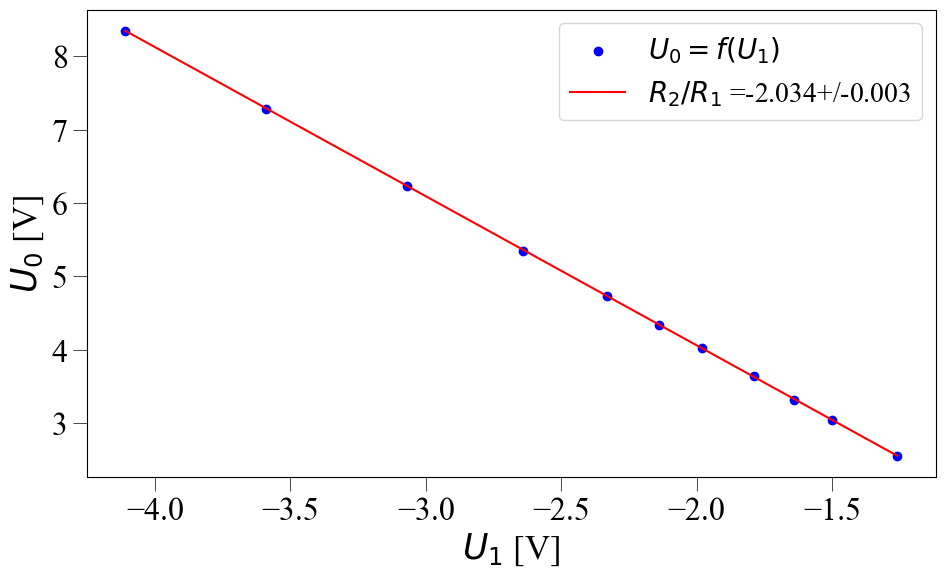

In [82]:
# Plot for inverted input

colors = ['#FF7F0E','#D62728','#FFDB58','#2CA02C','#17BECF','#1F77B4','#F0027F']  
plt.rc("font", size=10)
plt.rcParams["font.family"] = "Times New Roman"

# Define the font size
ax_l_size = 25
l_size = 23

fig, ax = plt.subplots(figsize=(10, 6))

# ax.title.set_fontsize(ax_l_size)
ax.set_xlabel(r"$U_1$ [V]")
ax.xaxis.label.set_fontsize(ax_l_size)
ax.set_ylabel(r"$U_0$ [V]")
ax.yaxis.label.set_fontsize(ax_l_size)
ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=l_size)
ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=l_size)
# plt.xticks(rotation=45)
plt.tight_layout()  

ax.scatter(inv['U_1'], inv['U_0'], color='blue', label=r'$U_0 = f(U_1)$')
ax.plot(inv['U_1'], inv_fit, color='red', label=r'$R_2/R_1$ =' + f'{inv_alpha::.3f}')

ax.legend(loc='upper right', fontsize=20)


plt.show() 

fig.savefig('images/inv.png', bbox_inches='tight')

In [83]:
# Polynomial regression for inverted input
coefficients = np.polyfit(inv['f'][4:], inv['U_0_A'][4:], 3)
inv_freq_x = np.linspace(inv['f'][4:].min(), inv['f'][4:].max(), 100)
inv_freq_fit = np.poly1d(coefficients)

index = np.argwhere(np.diff(np.sign(inv_freq_fit(inv_freq_x) - A_u_max_inv))).flatten()
omega_max = 10**(inv_freq_x[index])

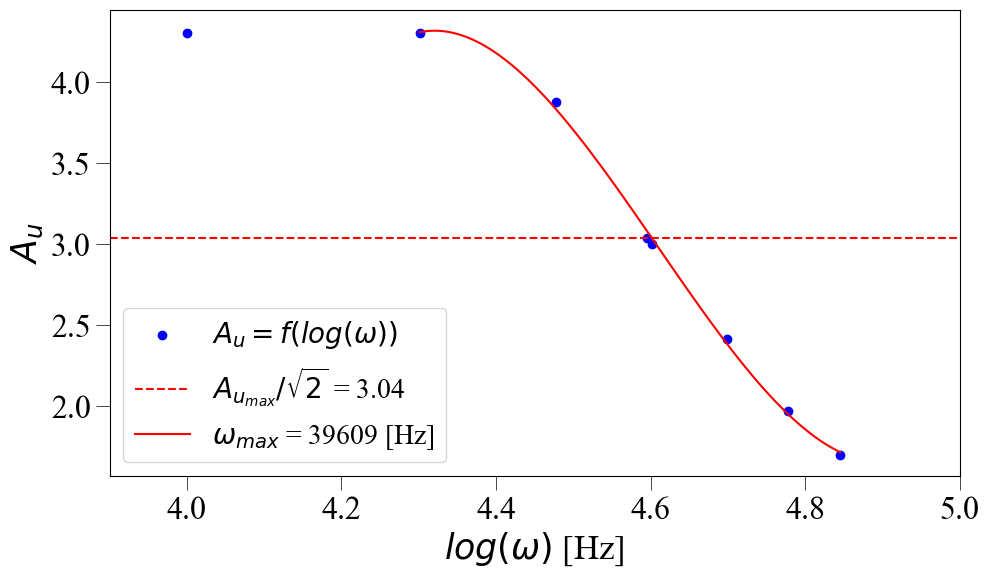

In [84]:
# Plot for inverted input (freq)

fig, ax = plt.subplots(figsize=(10, 6))

# ax.title.set_fontsize(ax_l_size)
ax.set_xlabel(r"$log(\omega)$ [Hz]")
ax.xaxis.label.set_fontsize(ax_l_size)
ax.set_ylabel(r"$A_u$")
ax.yaxis.label.set_fontsize(ax_l_size)
ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=l_size)
ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=l_size)
ax.set_xlim(3.9, 5)
plt.tight_layout()  

ax.scatter(inv['f'], inv['U_0_A'], color='blue', label=r'$A_u = f(log(\omega))$')
ax.axhline(y=A_u_max_inv, color='red', linestyle='--', label=r'$A_{u_{max}}/\sqrt{2}$ = ' + f'{A_u_max_inv:.2f}')
ax.plot(inv_freq_x, inv_freq_fit(inv_freq_x), color='red', label=r'$\omega_{max}$ = ' + f'{omega_max[0]:.0f} [Hz]')

ax.legend(loc='lower left', fontsize=20)

plt.show() 

fig.savefig('images/inv_freq.png', bbox_inches='tight')

In [85]:
# Polynomial regression for low pass filter
coefficients = np.polyfit(low['f'][2:], low['U_0'][2:], 3)
low_x = np.linspace(low['f'][2:].min(), low['f'][2:].max(), 100)
low_fit = np.poly1d(coefficients)

index = np.argwhere(np.diff(np.sign(low_fit(low_x) - A_u_max_low))).flatten()
omega_max = 10**(low_x[index])

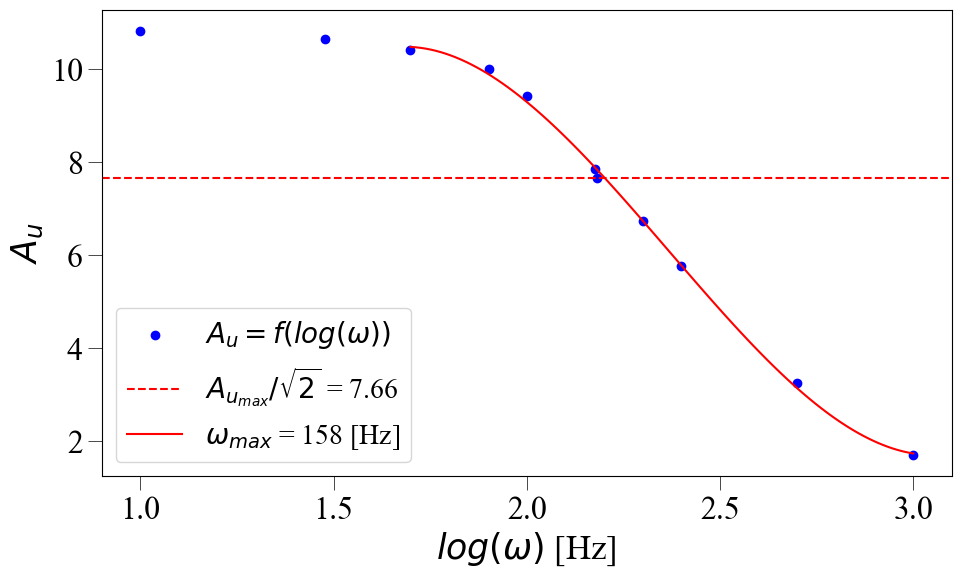

In [86]:
# Plot for low pass filter

fig, ax = plt.subplots(figsize=(10, 6))

# ax.title.set_fontsize(ax_l_size)
ax.set_xlabel(r"$log(\omega)$ [Hz]")
ax.xaxis.label.set_fontsize(ax_l_size)
ax.set_ylabel(r"$A_u$")
ax.yaxis.label.set_fontsize(ax_l_size)
ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=l_size)
ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=l_size)
# ax.set_xlim(9, 11.5)
plt.tight_layout()  

ax.scatter(low['f'], low['U_0'], color='blue', label=r'$A_u = f(log(\omega))$')
ax.axhline(y=A_u_max_low, color='red', linestyle='--', label=r'$A_{u_{max}}/\sqrt{2}$ = ' + f'{A_u_max_low:.2f}')
ax.plot(low_x, low_fit(low_x), color='red', label=r'$\omega_{max}$ = ' + f'{omega_max[0]:.0f} [Hz]')

ax.legend(loc='lower left', fontsize=20)

plt.show() 

fig.savefig('images/low.png', bbox_inches='tight')

In [87]:
# Linear regression for differentiator

slope, intercept, r_value, p_value, std_err = stats.linregress(diff['dU'], diff['U_0'])

diff_alpha = ufloat(slope, std_err)
print('diff_alpha =', diff_alpha)

#Best fit line 
diff_fit = slope * np.array(diff['dU']) + intercept

diff_alpha = 2.0196+/-0.0026


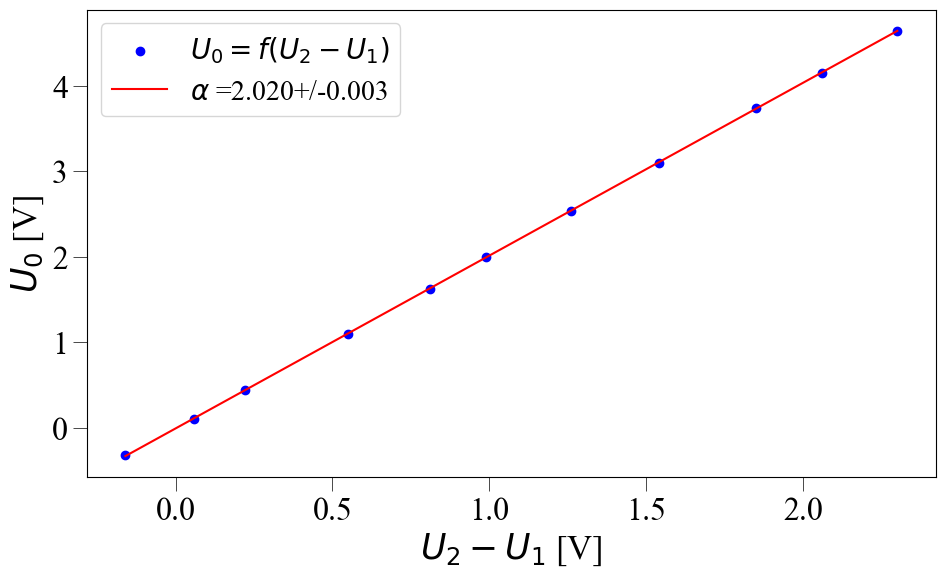

In [88]:
# Plot for differentiator

fig, ax = plt.subplots(figsize=(10, 6))

# ax.title.set_fontsize(ax_l_size)
ax.set_xlabel(r"$U_2 - U_1$ [V]")
ax.xaxis.label.set_fontsize(ax_l_size)
ax.set_ylabel(r"$U_0$ [V]")
ax.yaxis.label.set_fontsize(ax_l_size)
ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=l_size)
ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=l_size)
# plt.xticks(rotation=45)
plt.tight_layout()  

ax.scatter(diff['dU'], diff['U_0'], color='blue', label=r'$U_0 = f(U_2 - U_1)$')
ax.plot(diff['dU'], diff_fit, color='red', label=r'$\alpha$ =' + f'{diff_alpha:.3f}')

ax.legend(loc='upper left', fontsize=20)

plt.show() 

fig.savefig('images/diff.png', bbox_inches='tight')

In [89]:
# Linear regression for non-inverted input 1

slope, intercept, r_value, p_value, std_err = stats.linregress(non_inv['U_1_1'], non_inv['U_0_1'])

non_inv_1_alpha = ufloat(slope, std_err)
print('non_inv_1_alpha =', non_inv_1_alpha)

#Best fit line 
non_inv_1_fit = slope * np.array(non_inv['U_1_1']) + intercept

# Linear regression for non-inverted input 2

slope, intercept, r_value, p_value, std_err = stats.linregress(non_inv['U_1_2'], non_inv['U_0_2'])

non_inv_2_alpha = ufloat(slope, std_err)
print('non_inv_2_alpha =', non_inv_2_alpha)

#Best fit line
non_inv_2_fit = slope * np.array(non_inv['U_1_2']) + intercept

non_inv_1_alpha = 2.986+/-0.027
non_inv_2_alpha = 1.4997+/-0.0011


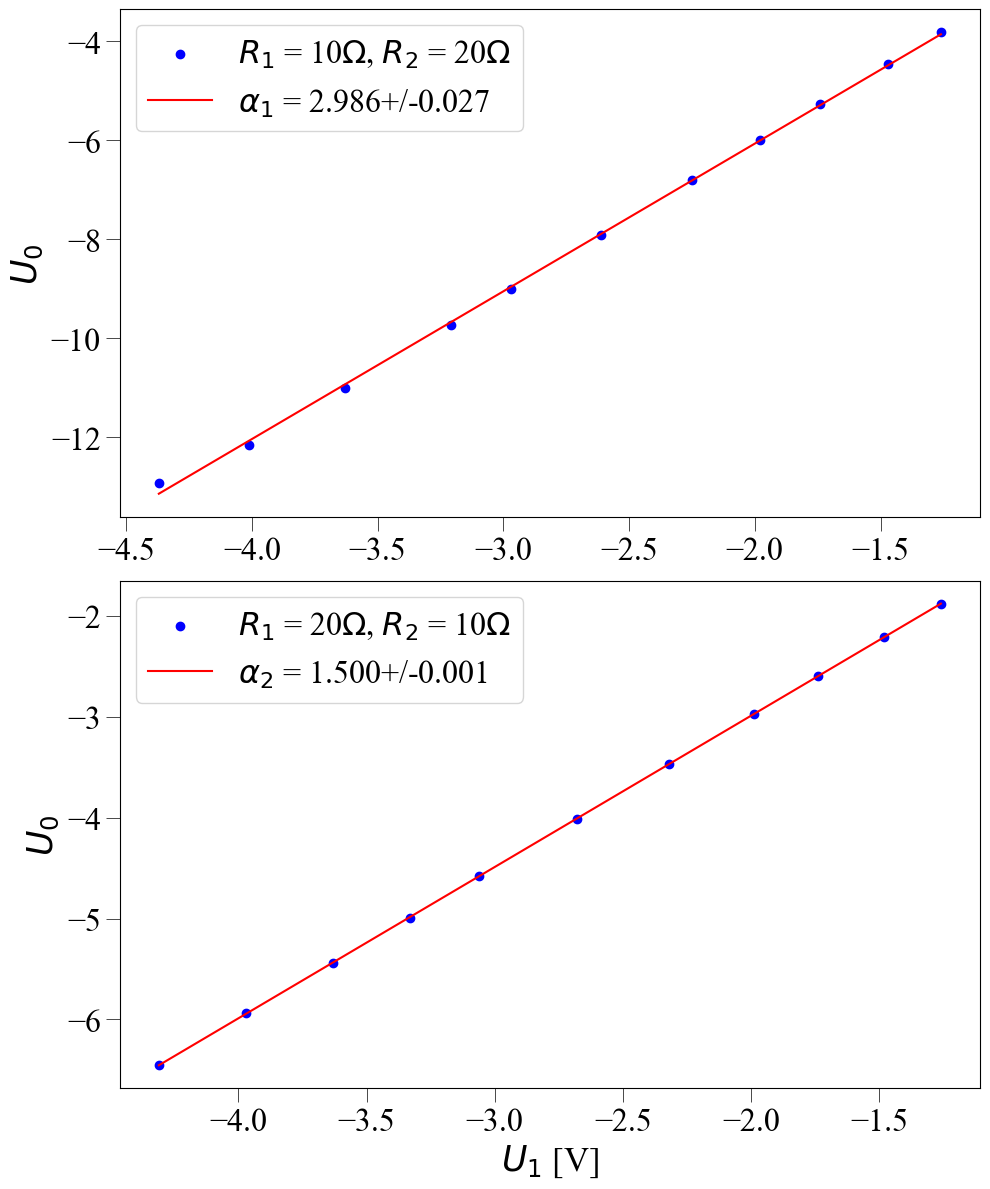

In [90]:
# Define the figure and the subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Define the font size
ax_l_size = 25
l_size = 23

# Plot for non-inverted input 1
ax1.set_ylabel(r"$U_0$")
ax1.xaxis.label.set_fontsize(ax_l_size)
ax1.yaxis.label.set_fontsize(ax_l_size)
ax1.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=l_size)
ax1.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=l_size)
# ax1.set_xlim(-5.3,0.3)
# ax1.set_ylim(-25,-15)
ax1.scatter(non_inv['U_1_1'], non_inv['U_0_1'], color='blue', label=r'$R_1$ = ' + f'{R_1_1_noninv}' + r'$\Omega$' + r', $R_2$ = ' + f'{R_2_1_noninv}' + r'$\Omega$')
ax1.plot(non_inv['U_1_1'], non_inv_1_fit, color='red', label=r'$\alpha_1$ = ' + f'{non_inv_1_alpha:.3f}')

ax1.legend(loc='upper left', fontsize=23)

# Plot for non-inverted input 2
ax2.set_xlabel(r"$U_1$ [V]")
ax2.set_ylabel(r"$U_0$")
ax2.xaxis.label.set_fontsize(ax_l_size)
ax2.yaxis.label.set_fontsize(ax_l_size)
ax2.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=l_size)
ax2.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=l_size)
# ax2.set_xlim(-5.3,0.3)
# ax2.set_ylim(-23,-16)
ax2.scatter(non_inv['U_1_2'], non_inv['U_0_2'], color='blue', label=r'$R_1$ = ' + f'{R_1_2_noninv}' + r'$\Omega$' + r', $R_2$ = ' + f'{R_2_2_noninv}' + r'$\Omega$')
ax2.plot(non_inv['U_1_2'], non_inv_2_fit, color='red', label=r'$\alpha_2$ = ' + f'{non_inv_2_alpha:.3f}')

ax2.legend(loc='upper left', fontsize=23)

plt.tight_layout()
plt.show()

fig.savefig('images/non_inv.png', bbox_inches='tight')

In [91]:
inv = inv.round(2)
non_inv = non_inv.round(2)
diff = diff.round(2)
low = low.round(2)

inv.to_csv('data/inv_out.csv', index=False)
non_inv.to_csv('data/non_inv_out.csv', index=False)
diff.to_csv('data/diff_out.csv', index=False)
low.to_csv('data/low_out.csv', index=False)


In [95]:
diff

,U_0,U_1,U_2,dU
0,4.64,-3.56,-1.26,2.30
1,4.15,-3.56,-1.50,2.06
2,3.74,-3.56,-1.71,1.85
3,3.10,-3.56,-2.02,1.54
4,2.54,-3.56,-2.30,1.26
5,2.00,-3.56,-2.57,0.99
6,1.62,-3.56,-2.75,0.81
7,1.10,-3.56,-3.01,0.55
8,0.44,-3.56,-3.34,0.22
9,0.11,-3.56,-3.50,0.06
